# パッケージインストール

In [1]:
!pip install -q git+https://github.com/huggingface/transformers accelerate
!pip install -q qwen-vl-utils[decord]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.0/515.0 kB 28.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0.dev0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 119.4 MB/s eta 0:00:00


# サンプル画像ダウンロード

In [2]:
!wget https://raw.githubusercontent.com/Kazuhito00/Qwen3-VL-Colaboratory-Sample/refs/heads/main/sample.jpg -O sample.jpg

--2025-11-13 01:02:09--  https://raw.githubusercontent.com/Kazuhito00/Qwen3-VL-Colaboratory-Sample/refs/heads/main/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133381 (130K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 130.25K  --.-KB/s    in 0.003s  

2025-11-13 01:02:09 (38.0 MB/s) - ‘sample.jpg’ saved [133381/133381]



# モデル読み込み

In [3]:
# モデル選択
model_path = "Qwen/Qwen3-VL-4B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-4B-Thinking"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Instruct"  # T4 GPU
# model_path = "Qwen/Qwen3-VL-8B-Thinking"  # T4 GPU

In [4]:
from transformers import Qwen3VLForConditionalGeneration, AutoTokenizer, AutoProcessor

model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

# プロンプト生成

In [5]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "画像を説明してください"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [6]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=4096)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 1min 18s, sys: 537 ms, total: 1min 18s
Wall time: 1min 19s


# 結果確認

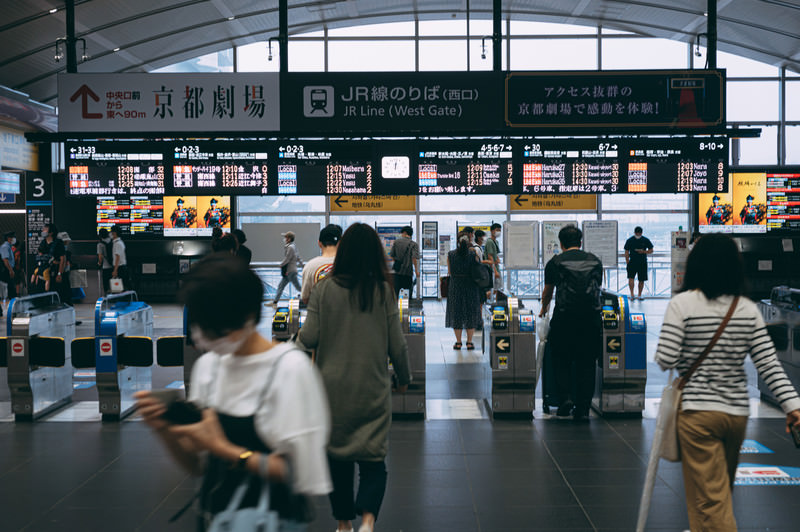

In [7]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('sample.jpg')
cv2_imshow(image)

In [8]:
import textwrap

print(textwrap.fill(output_text[0], width=50))

この画像は、日本の駅（おそらく京都駅）の改札口付近を捉えたもので、多くの人々が行き交う様子が写ってい
ます。以下に詳細を説明します。  ---  ### **1. 基本的な構造と場所** -
**駅名**: 画像上部の看板には「京都劇場」の文字が見え、これは「京都駅」の一部である「京都劇場」
（京都市役所や京都駅の一部としての商業施設）を指している可能性があります。 - **改札口**:
多くの人が通る「JR線のりば（西口）」の改札口が写っており、左側には「JR Line (West
Gate)」と英語で表記されています。 - **アクセス案内**:
「アクセス抜群の京都劇場で体験！」という看板があり、観光客や観光地へのアクセスを強調しています。
---  ### **2. 駅内と設備** - **電光掲示板**: 大きな電子掲示板があり、各列車
の到着・出発時刻（例：12:13、12:23、12:33など）や列車の種別（例：「特急」、「快速」）
が表示されています。掲示板には、列車の画像や駅名、行先（例：「大阪」、「奈良」）も含まれています。
- **改札機**: 鉄道の改札機（自動改札機）が並んでおり、多くの人が通過しています。一部の改札機
には「JR」のロゴが見えます。 - **天井と照明**:
駅の天井は高く、大きな窓から自然光が差し込んでおり、照明も明るく、清潔感のある空間です。  ---
### **3. 人々の様子** - **通行中の乗客**: 画像の中心には、多くの人が行き交ってお
り、それぞれが自分の目的地に向かって歩いている様子が見られます。 - **女性の人物**: 画像の中
央や右側には、女性が写っており、一人は白いマスクを着用し、スマートフォンを操作している様子が見えます
。他の女性はカジュアルな服装で、手にバッグを持ちながら歩いている。 - **男性の人物**: 画像の
右側には、黒いジャケットを着た男性が見え、リュックサックを背負いながら歩いている様子が写っています。
---  ### **4. 環境と雰囲気** - **混雑**:
画像の写真は、多くの人が駅内で移動している様子を捉えており、混雑している様子が伝わってきます。 -
**現代的で活気ある雰囲気**:
駅の設備や人々の動きから、現代的な都市の駅としての活気と機能性が感じら

# プロンプト生成

In [9]:
from qwen_vl_utils import process_vision_info

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "sample.jpg"},
            {"type": "text", "text": "物体検出でマスクをかけた人物を検出してください。バウンディングボックス座標とラベル名はJSON形式で出力してください。JSONのラベル名は英語で出力してください。"},
        ],
    }
]
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# 推論

In [14]:
%%time

generated_ids = model.generate(**inputs, max_new_tokens=16384)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

CPU times: user 23.7 s, sys: 447 ms, total: 24.1 s
Wall time: 24.1 s


# 結果確認

In [15]:
import textwrap

print(output_text[0])

```json
[
	{"bbox_2d": [165, 485, 417, 1000], "label": "Masked person"},
	{"bbox_2d": [554, 435, 604, 659], "label": "Masked person"},
	{"bbox_2d": [122, 425, 152, 554], "label": "Masked person"},
	{"bbox_2d": [330, 438, 378, 577], "label": "Masked person"}
]
```


In [16]:
import copy
import json
import re
import cv2
import random


def draw_bboxes_from_json_str(json_str: str, image):
    # ```json ～ ``` の中を抽出
    match = re.search(r"```json(.*?)```", json_str, flags=re.DOTALL)
    if not match:
        raise ValueError("JSON が ```json ... ``` の形式で見つかりません")

    json_body = match.group(1)

    # JSON をパース
    try:
        data = json.loads(json_body)
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON パースエラー: {e}")

    debug_image = copy.deepcopy(image)

    # ---- ラベルごとの色定義 ----
    # 必要に応じて追加
    label_colors = {
        "person":     (0, 255, 0),     # green
        "car":        (0, 0, 255),     # red
    }

    # 未登録ラベルの色を保持（毎回ランダム生成し、同じラベルは同じ色を使う）
    random_color_cache = {}

    def get_color(label: str):
        if label in label_colors:
            return label_colors[label]

        if label not in random_color_cache:
            random_color_cache[label] = (
                random.randint(50, 255),
                random.randint(50, 255),
                random.randint(50, 255)
            )
        return random_color_cache[label]

    # 描画
    for obj in data:
        bbox = obj["bbox_2d"]
        label = obj["label"]

        height, width = image.shape[:2]

        # x1, y1, x2, y2   (0-1000 正規化 → pixel)
        x1 = int(bbox[0] / 1000 * width)
        y1 = int(bbox[1] / 1000 * height)
        x2 = int(bbox[2] / 1000 * width)
        y2 = int(bbox[3] / 1000 * height)

        # ラベルごとの色
        color = get_color(label)

        # bbox
        cv2.rectangle(debug_image, (x1, y1), (x2, y2), color, 2)

        # label
        cv2.putText(
            debug_image,
            label,
            (x1, y1 - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.75,
            color,
            2
        )

    return debug_image

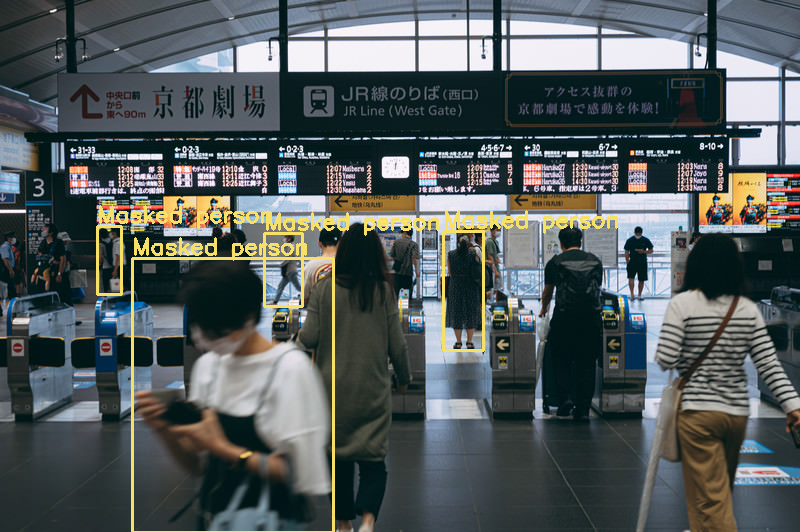

In [17]:
debug_image = draw_bboxes_from_json_str(output_text[0], image)

cv2_imshow(debug_image)